In [1]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Article Loader

In [2]:
char2ind = {}
def data_init():
    global char2ind
    with open("../Datasets/penn/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("../Datasets/penn/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("../Datasets/penn/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  
        if toekn == iToken:
            return word
    return ''

In [3]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Own Loader

In [4]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset,tokenizer):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [5]:
train_dataset = load_dataset("../Datasets/penn/train.txt")
valid_dataset = load_dataset("../Datasets/penn/valid.txt")
test_dataset = load_dataset("../Datasets/penn/test.txt")

In [6]:
b_tokenizer = get_tokenizer("basic_english")
b_train_tokens = tokenize_dataset(train_dataset,b_tokenizer)
b_valid_tokens = tokenize_dataset(valid_dataset,b_tokenizer)
b_test_tokens = tokenize_dataset(test_dataset,b_tokenizer)

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']
b_vocab = build_vocab_from_iterator([b_train_tokens], specials=special_tokens , min_freq=0)
b_vocab.set_default_index(b_vocab['<unk>'])
torch.save(b_vocab, f"./vocab_penn_basicEnglish.voc")

In [7]:
m_tokenizer = get_tokenizer("moses")
m_train_tokens = tokenize_dataset(train_dataset,m_tokenizer)
m_valid_tokens = tokenize_dataset(valid_dataset,m_tokenizer)
m_test_tokens = tokenize_dataset(test_dataset,m_tokenizer)

m_vocab = build_vocab_from_iterator([m_train_tokens], specials=special_tokens , min_freq=0)
m_vocab.set_default_index(m_vocab['<unk>'])
torch.save(m_vocab, f"./vocab_penn_moses.voc")

# EDA

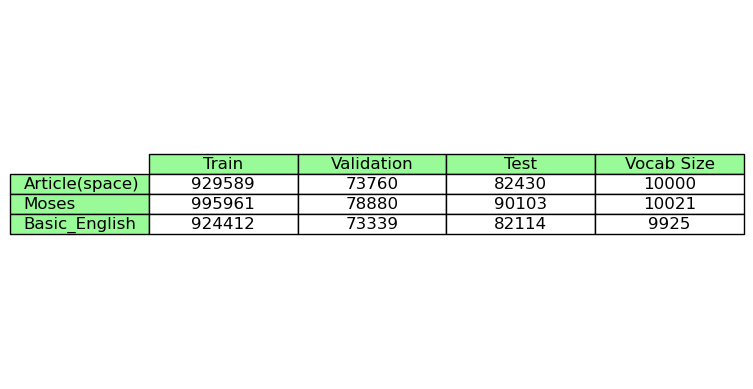

In [8]:
columns = ['Train', 'Validation', 'Test','Vocab Size']
index = ['Article(space)', 'Moses','Basic_English']
data = [
    [ len(train_tokens_voc) , len(valid_tokens_voc) , len(test_tokens_voc) , vocab_size],
    [ len(m_train_tokens) , len(m_valid_tokens) , len(m_test_tokens) , len(m_vocab)],
    [ len(b_train_tokens) , len(b_valid_tokens) , len(b_test_tokens) , len(b_vocab)]
]

df = pd.DataFrame(data, columns=columns, index=index)
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=columns, rowLabels=index,
                 loc='center', cellLoc ='center',
                 colColours =["palegreen"]* 4 , rowColours =["palegreen"]* 4 )
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

# Tokens Frequencies

In [9]:
def wordFreqToList(commons):
    words = []
    freqs = []
    for word, freq in commons:
        words.append(word)
        freqs.append(freq)
    return words,freqs

In [10]:
a_word_freqs = Counter(char2ind)
a_most_common_words = a_word_freqs.most_common(20)
a_least_common_words = a_word_freqs.most_common()[:-21:-1]

b_word_freqs = Counter(b_vocab.get_stoi())
b_most_common_words = b_word_freqs.most_common(20)
b_least_common_words = b_word_freqs.most_common()[:-21:-1]

m_word_freqs = Counter(m_vocab.get_stoi())
m_most_common_words = m_word_freqs.most_common(20)
m_least_common_words = m_word_freqs.most_common()[:-21:-1]

In [11]:
a_most_word , a_most_freq = wordFreqToList(a_most_common_words)
a_least_word , a_least_freq = wordFreqToList(a_least_common_words)

b_most_word , b_most_freq = wordFreqToList(b_most_common_words)
b_least_word , b_least_freq = wordFreqToList(b_least_common_words)

m_most_word , m_most_freq = wordFreqToList(m_most_common_words)
m_least_word , m_least_freq = wordFreqToList(m_least_common_words)

In [12]:
def showBarplot(title, most_freq , least_freq , most_word , least_word):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sns.barplot(x=most_freq, y=most_word, ax=ax[0])
    ax[0].set_xlim(most_freq[len(most_freq)-1]-5,most_freq[0]) 
    ax[0].set_title('Top 10 Most Frequently Words')
    for i, (freq, word) in enumerate(zip(most_freq, most_word)):
        ax[0].text(freq, i, f'{freq}', ha='right', va='center')

    sns.barplot(x=least_freq, y=least_word, ax=ax[1])
    ax[1].set_title('Top 10 Least Frequently Words')
    for i, (freq, word) in enumerate(zip(least_freq, least_word)):
        ax[1].text(freq, i, f'{freq}', ha='left', va='center')
    
    fig.suptitle(title)
    plt.show()

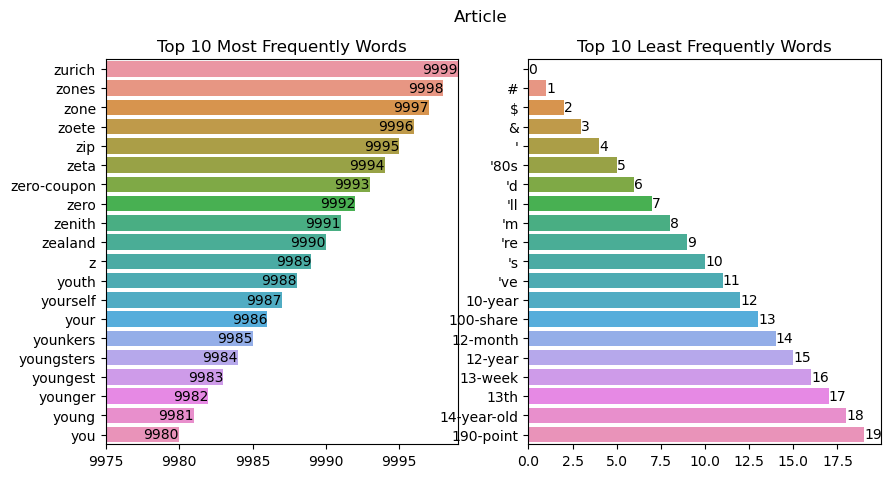

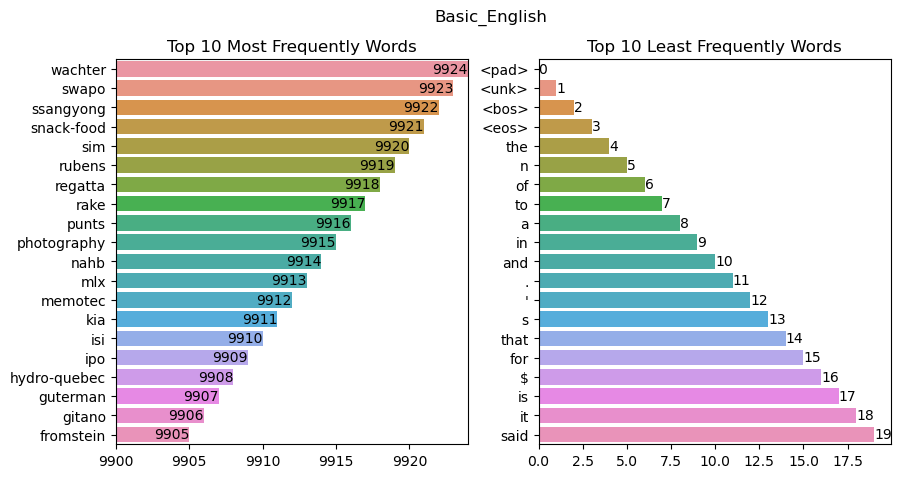

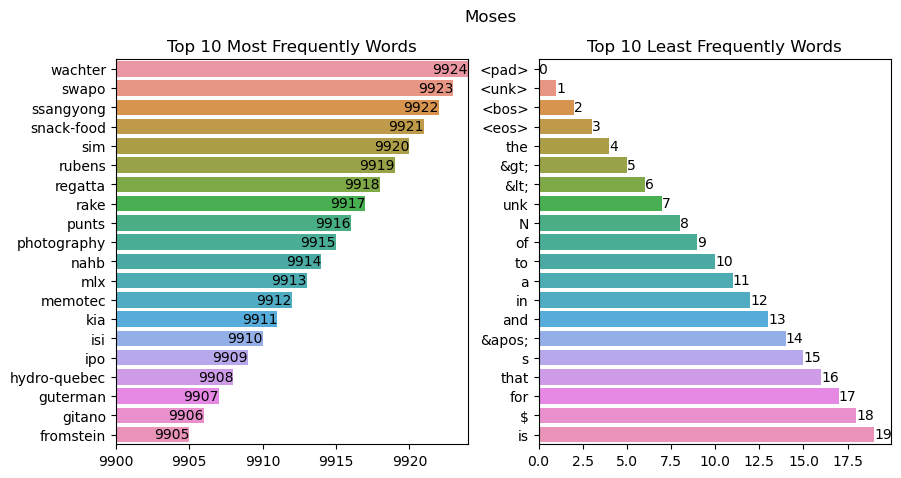

In [13]:
showBarplot("Article", a_most_freq , a_least_freq , a_most_word , a_least_word)
showBarplot("Basic_English", b_most_freq , b_least_freq , b_most_word , b_least_word)
showBarplot("Moses", b_most_freq , b_least_freq , b_most_word , m_least_word)

# Sequence Length

In [14]:
train_content = load_dataset("../Datasets/penn/train.txt").split(".")
means = 0
for sen in train_content:
    means += len(sen.split(" "))
sentense_mean = means // len(train_content)
print(f"Mean Sentense: {sentense_mean}")

Mean Sentense: 56
